# Wilkinson Power Divider

In this notebook we create a [Wilkinson power divider](https://www.microwaves101.com/encyclopedias/wilkinson-power-splitters), which splits an input signal into two equals phase output signals. Theoritecal results about this circuit are exposed in reference [1]. Here we will reproduce the ideal circuit illustrated below and discussed in reference [2]. In this example, the circuit is designed to operate at 1 GHz.

![](wilkinson_power_divider.png)

 - [1] P. Hallbjörner, Microw. Opt. Technol. Lett. 38, 99 (2003).
 - [2] Microwaves 101: "Wilkinson Power Splitters" 

In [1]:
# standard imports
import numpy as np
import matplotlib.pyplot as plt


In [2]:
import skrf as rf
rf.stylely()

In [3]:
# frequency band
freq = rf.Frequency(start=0, stop=2, npoints=501, unit='GHz')

# characteristic impedance of the ports
Z0_ports = 50

# resistor
R = 100
line_resistor = rf.media.DefinedGammaZ0(frequency=freq, Z0=R)
resistor = line_resistor.resistor(R, name='resistor')

# branches
Z0_branches = np.sqrt(2)*Z0_ports
beta = freq.w/rf.c
line_branches = rf.media.DefinedGammaZ0(frequency=freq, Z0=Z0_branches, gamma=0+beta*1j)

d = line_branches.theta_2_d(90, deg=True)  # @ 90°(lambda/4)@ 1 GHz is ~ 75 mm
branch1 = line_branches.line(d, unit='m', name='branch1')
branch2 = line_branches.line(d, unit='m', name='branch2')

# ports
port1 = rf.Circuit.Port(freq, name='port1', z0=50)
port2 = rf.Circuit.Port(freq, name='port2', z0=50)
port3 = rf.Circuit.Port(freq, name='port3', z0=50)

# Connection setup
#┬Note that the order of appearance of the port in the setup is important 
connections = [
           [(port1, 0), (branch1, 0), (branch2, 0)],
           [(port2, 0), (branch1, 1), (resistor, 0)],
           [(port3, 0), (branch2, 1), (resistor, 1)]
        ]

# Building the circuit
C = rf.Circuit(connections)

The circuit setup can be checked by visualising the circuit graph (this requires the python package `networkx` to be available). 

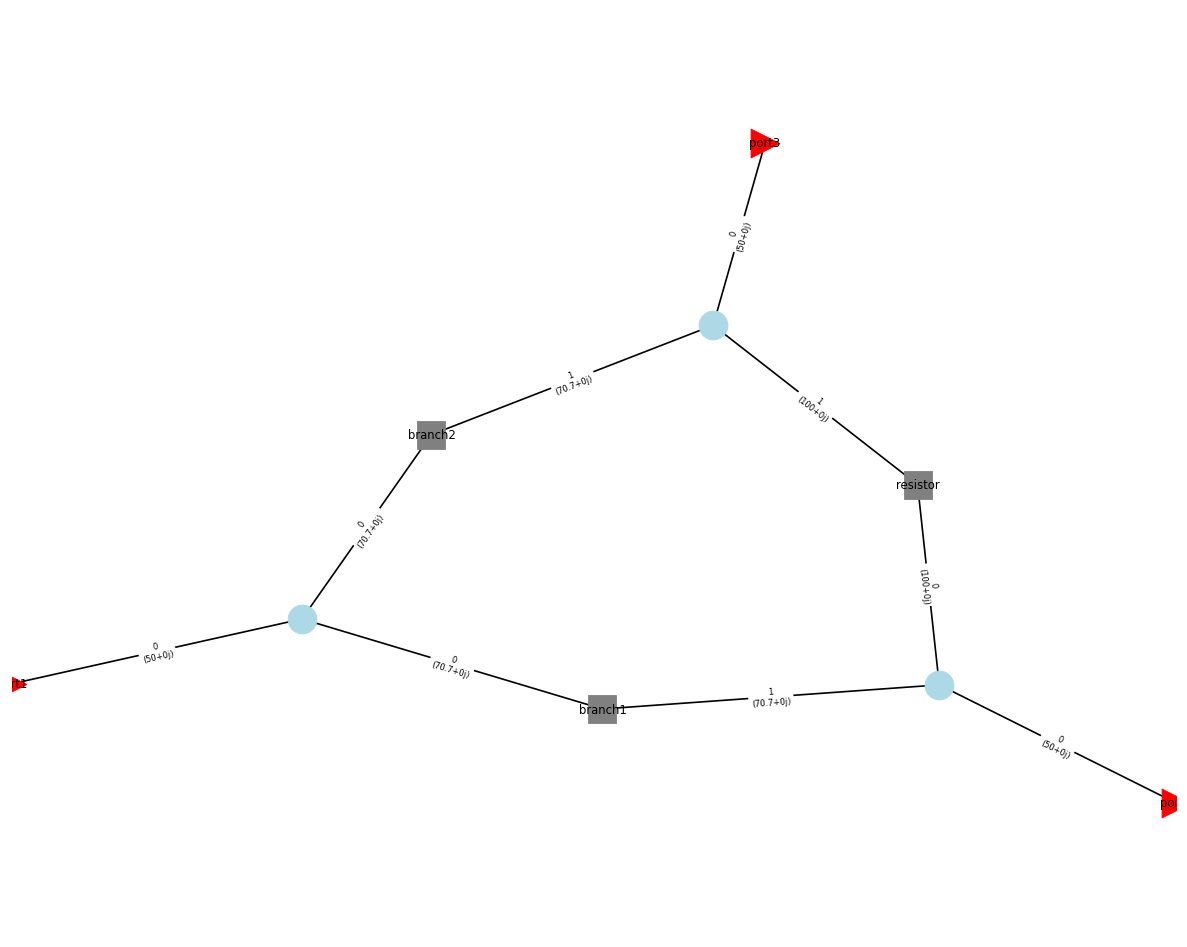

In [4]:
C.plot_graph(network_labels=True, edge_labels=True, port_labels=True, port_fontize=2)

Let's look to the scattering parameters of the circuit:

Text(0.5, 0.98, 'Ideal Wilkinson Divider @ 1 GHz')

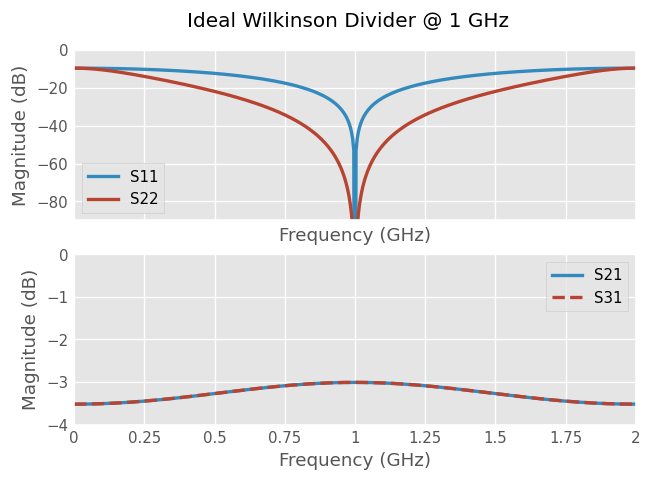

In [5]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
C.network.plot_s_db(ax=ax1, m=0, n=0,  lw=2)  # S11
C.network.plot_s_db(ax=ax1, m=1, n=1,  lw=2)  # S22
ax1.set_ylim(-90, 0)
C.network.plot_s_db(ax=ax2, m=1, n=0,  lw=2)  # S21
C.network.plot_s_db(ax=ax2, m=2, n=0,  ls='--', lw=2)  # S31
ax2.set_ylim(-4, 0)
fig.suptitle('Ideal Wilkinson Divider @ 1 GHz')

## Currents and Voltages
Is is possible to calculate currents and voltages at the Circuit's internals ports. However, if you try with this specific example, one obtains: 

In [ ]:
power = [1,0,0]
phase = [0,0,0]
C.voltages(power, phase)  # or C.currents(power, phase)

This situation is "normal", in the sense that the voltages and currents calculation methods does not support the case of more than 2 ports are connected together, which is the case in this example, as we have defined the connection list:

```
connections = [
           [(port1, 0), (branch1, 0), (branch2, 0)],
           [(port2, 0), (branch1, 1), (resistor, 0)],
           [(port3, 0), (branch2, 1), (resistor, 1)]
        ]
```

However, note that the voltages and currents calculations at external ports works:

In [ ]:
C.voltages_external(power, phase)  # or C.currents_external(power, phase)

But there is hope! It is possible to calculate the internal voltages and currents of the circuit using intermediate splitting Networks. In our case, one needs three "T" Networks and to make only pair of connections: 

In [ ]:
tee1 = line_branches.tee(name='tee1')
tee2 = line_branches.tee(name='tee2')
tee3 = line_branches.tee(name='tee3')

cnx = [
    [(port1, 0), (tee1, 0)],
    [(tee1, 1), (branch1, 0)],
    [(tee1, 2), (branch2, 0)],
    [(branch1, 1), (tee2, 0)],
    [(branch2, 1), (tee3, 0)],
    [(tee2, 2), (resistor, 0)],
    [(tee3, 2), (resistor, 1)],
    [(tee3, 1), (port3, 0)],
    [(tee2, 1), (port2, 0)],   
]
C2 = rf.Circuit(cnx)

The resulting graph is a bit more stuffed:

In [ ]:
C2.plot_graph(network_labels=True, edge_labels=True, port_labels=True, port_fontize=2)

But the results are the same:

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
C2.network.plot_s_db(ax=ax1, m=0, n=0,  lw=2)  # S11
C2.network.plot_s_db(ax=ax1, m=1, n=1,  lw=2)  # S22
ax1.set_ylim(-90, 0)
C2.network.plot_s_db(ax=ax2, m=1, n=0,  lw=2)  # S21
C2.network.plot_s_db(ax=ax2, m=2, n=0,  ls='--', lw=2)  # S31
ax2.set_ylim(-4, 0)
fig.suptitle('Ideal Wilkinson Divider (2nd way) @ 1 GHz')

And this time one can calculate internal voltages and currents:

In [ ]:
C2.voltages(power, phase)  # or C2.currents(power, phase)

You will find more details on voltages and currents calculation on the dedicated example.